In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '..')

import os
import definition
from ner import Reader, Extractor, BiLstmCrfTagger, UnaryBatchGenerator
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Validation

In [2]:
train_ratio = 0.75

raw_data = Reader.read_file(definition.DATA_PAIRED_SAMPLE)
index = np.arange(len(raw_data))
np.random.shuffle(index)
index_train = index[:int(train_ratio * len(raw_data))]
index_test = index[int(train_ratio * len(raw_data)):]
raw_data_train = np.array(raw_data)[index_train].tolist()
raw_data_test = np.array(raw_data)[index_test].tolist()

In [3]:
print(len(raw_data_train))
print(len(raw_data_test))

2023
675


In [4]:
embedding_filename = "fasttext_25.bin"

extractor = Extractor(embedding_filename=os.path.join(definition.MODEL_EMBEDDING, embedding_filename))
X_train, y_train = extractor.extract_data(raw_data_train)
X_test, y_test = extractor.extract_data(raw_data_test)

Extracting data: 100%|██████████████████████████████████████████████████████████| 2023/2023 [00:00<00:00, 57840.84it/s]


Encoding model not found. It will be generated.


Extracting data: 100%|████████████████████████████████████████████████████████████| 675/675 [00:00<00:00, 61397.36it/s]


In [5]:
filename_encoder_validation = "encoder_validation.pkl"

extractor.save_encoder_model(os.path.join(definition.MODEL_NER, filename_encoder_validation))

In [6]:
X_train[0].shape

(26, 3139)

In [7]:
np.array(y_train[0]).shape

(26, 5)

In [8]:
n_features = X_train[0].shape[1]
n_lstm_unit = 100
n_distributed_dense = 50
n_tags = 5

print(n_features, n_lstm_unit, n_distributed_dense, n_tags)

3139 100 50 5


In [9]:
model = BiLstmCrfTagger(n_features=n_features, n_lstm_unit=n_lstm_unit, n_distributed_dense=n_distributed_dense, n_tags=n_tags)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
train_generator = UnaryBatchGenerator(X_train, y_train)
val_generator = UnaryBatchGenerator(X_test[:len(X_test)//2], y_test[:len(y_test)//2])

In [11]:
history = model.fit_generator(generator=train_generator, epochs=10, verbose=2, validation_data=val_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 179s - loss: 0.4883 - crf_accuracy: 0.8044 - val_loss: 0.2206 - val_crf_accuracy: 0.8846
Epoch 2/10
 - 177s - loss: 0.1337 - crf_accuracy: 0.8987 - val_loss: 0.0467 - val_crf_accuracy: 0.9115
Epoch 3/10
 - 181s - loss: -8.5009e-03 - crf_accuracy: 0.9170 - val_loss: -4.1448e-02 - val_crf_accuracy: 0.9129
Epoch 4/10
 - 178s - loss: -1.3425e-01 - crf_accuracy: 0.9271 - val_loss: -1.6607e-01 - val_crf_accuracy: 0.9185
Epoch 5/10
 - 178s - loss: -2.5353e-01 - crf_accuracy: 0.9353 - val_loss: -2.7773e-01 - val_crf_accuracy: 0.9188
Epoch 6/10
 - 178s - loss: -3.7675e-01 - crf_accuracy: 0.9425 - val_loss: -3.7587e-01 - val_crf_accuracy: 0.9143
Epoch 7/10
 - 178s - loss: -5.0370e-01 - crf_accuracy: 0.9477 - val_loss: -5.1078e-01 - val_crf_accuracy: 0.9194
Epoch 8/10
 - 177s - loss: -6.3164e-01 - crf_accuracy: 0.9546 - val_loss: -5.9059e-01 - val_crf_accuracy: 0.9193
Epoch 9/10
 - 177s - loss: -7.5998e-01 - crf_accuracy: 0.9594 - val_

In [18]:
progress = pd.DataFrame(history.history)
progress

,val_loss,val_crf_accuracy,loss,crf_accuracy
0,0.220616,0.884622,0.488315,0.804414
1,0.046712,0.911499,0.133724,0.898746
2,-0.041448,0.912903,-0.008501,0.916970
3,-0.166068,0.918497,-0.134253,0.927065
4,-0.277729,0.918833,-0.253535,0.935265
5,-0.375867,0.914346,-0.376751,0.942475
6,-0.510783,0.919449,-0.503699,0.947698
7,-0.590586,0.919265,-0.631641,0.954634
8,-0.683756,0.909895,-0.759982,0.959388
9,-0.817962,0.910884,-0.893365,0.963655


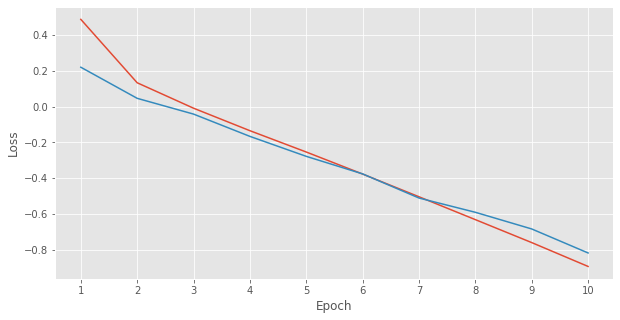

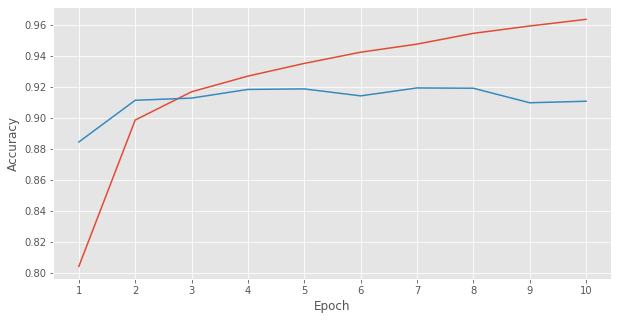

In [25]:
plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(progress["loss"])
plt.plot(progress["val_loss"])
plt.xticks(range(len(progress)), progress.index+1)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.style.use("ggplot")
plt.figure(figsize=(10,5))
plt.plot(progress["crf_accuracy"])
plt.plot(progress["val_crf_accuracy"])
plt.xticks(range(len(progress)), progress.index+1)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 3139)        0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         2592000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 50)          10050     
_________________________________________________________________
crf_1 (ClassWrapper)         (None, None, 5)           290       
Total params: 2,602,340
Trainable params: 2,602,340
Non-trainable params: 0
_________________________________________________________________


In [20]:
filename_tagger_validation = "tagger_validation.h5"

model.save(os.path.join(definition.MODEL_NER, filename_tagger_validation))

In [21]:
pred = []
for item in tqdm(X_test):
    pred.append(model.predict(np.array([item]))[0])

100%|████████████████████████████████████████████████████████████████████████████████| 675/675 [00:17<00:00, 32.42it/s]


In [22]:
pred_label = extractor.convert_y_matrix_to_label(pred).tolist()
y_test_label = extractor.convert_y_matrix_to_label(y_test).tolist()

In [23]:
pred_label_flatten = [token for sentence in pred_label for token in sentence]
y_test_label_flatten = [token for sentence in y_test_label for token in sentence]

In [24]:
print(classification_report(y_test_label_flatten, pred_label_flatten))

              precision    recall  f1-score   support

    B-ASPECT       0.90      0.86      0.88      1270
 B-SENTIMENT       0.90      0.89      0.89      1726
    I-ASPECT       0.83      0.70      0.76       405
 I-SENTIMENT       0.81      0.82      0.81       796
           O       0.92      0.94      0.93      6323

    accuracy                           0.90     10520
   macro avg       0.87      0.84      0.86     10520
weighted avg       0.90      0.90      0.90     10520

